<a href="https://colab.research.google.com/github/Firas2001-cyber/gdp-dashboard/blob/main/CFA%20Quant%20awards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt

In [23]:
ticker = "IVV"
start_date = "2018-01-01"
end_date = "2025-07-01"

# data = yf.download(ticker, start=start_date, end=end_date)
# prices = data['Close'].dropna()
# returns = prices.pct_change().dropna()

In [24]:
tickers = ["IVV", "VOO", "SPY", "VTI", "QQQ"]
data = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()
returns = data.pct_change().dropna()

/tmp/ipython-input-24-2751589459.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()
[*********************100%***********************]  5 of 5 completed


In [25]:
lw = LedoitWolf()
lw.fit(returns)
cov_matrix = lw.covariance_
shrunk_mean = lw.location_

In [26]:
print("Ledoit-Wolf Shrinkage Covariance Matrix:")
print(pd.DataFrame(cov_matrix, index=returns.columns, columns=returns.columns))

Ledoit-Wolf Shrinkage Covariance Matrix:
Ticker       IVV       QQQ       SPY       VOO       VTI
Ticker                                                  
IVV     0.000160  0.000181  0.000157  0.000158  0.000159
QQQ     0.000181  0.000239  0.000180  0.000181  0.000183
SPY     0.000157  0.000180  0.000157  0.000156  0.000158
VOO     0.000158  0.000181  0.000156  0.000159  0.000159
VTI     0.000159  0.000183  0.000158  0.000159  0.000164


In [27]:
print("\nShrunk Mean Vector:")
print(pd.Series(shrunk_mean, index=returns.columns))


Shrunk Mean Vector:
Ticker
IVV    0.000588
QQQ    0.000809
SPY    0.000585
VOO    0.000588
VTI    0.000565
dtype: float64


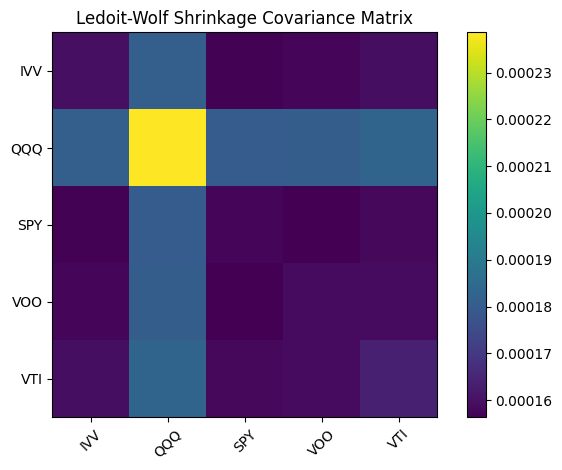

In [28]:
plt.imshow(cov_matrix, cmap='viridis')
plt.colorbar()
plt.title("Ledoit-Wolf Shrinkage Covariance Matrix")
plt.xticks(ticks=np.arange(len(returns.columns)), labels=returns.columns, rotation=45)
plt.yticks(ticks=np.arange(len(returns.columns)), labels=returns.columns)
plt.tight_layout()
plt.show()

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [30]:
class IVVSequenceDataset(Dataset):
    def __init__(self, ivv_returns, seq_len=30):
        self.X = []
        self.y = []
        for i in range(len(ivv_returns) - seq_len - 1):
            seq = ivv_returns[i:i+seq_len]
            next_day = ivv_returns[i+seq_len]
            label = int(next_day > 0)
            self.X.append(seq)
            self.y.append(label)
        self.X = torch.tensor(self.X, dtype=torch.float32).unsqueeze(-1)
        self.y = torch.tensor(self.y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ivv_returns = returns['IVV'].values
dataset = IVVSequenceDataset(ivv_returns)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [31]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, num_classes=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        logits = self.fc(out)
        return logits

def entropy_regularization(probs):
    entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=1)
    return torch.mean(entropy)

def custom_loss(logits, targets, lambda_entropy=0.01):
    ce_loss = F.cross_entropy(logits, targets)
    probs = F.softmax(logits, dim=1)
    entropy_penalty = entropy_regularization(probs)
    return ce_loss - lambda_entropy * entropy_penalty

In [32]:
model = LSTMClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for epoch in range(100):
    total_loss = 0
    for X_batch, y_batch in loader:
        logits = model(X_batch)
        loss = custom_loss(logits, y_batch, lambda_entropy=0.01)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 39.5703
Epoch 2, Loss: 39.5532
Epoch 3, Loss: 39.5919
Epoch 4, Loss: 39.5278
Epoch 5, Loss: 39.5438
Epoch 6, Loss: 39.5479
Epoch 7, Loss: 39.5333
Epoch 8, Loss: 39.5279
Epoch 9, Loss: 39.5267
Epoch 10, Loss: 39.5263
Epoch 11, Loss: 39.5274
Epoch 12, Loss: 39.5295
Epoch 13, Loss: 39.5334
Epoch 14, Loss: 39.5251
Epoch 15, Loss: 39.5280
Epoch 16, Loss: 39.5312
Epoch 17, Loss: 39.5248
Epoch 18, Loss: 39.5280
Epoch 19, Loss: 39.5363
Epoch 20, Loss: 39.5477
Epoch 21, Loss: 39.5251
Epoch 22, Loss: 39.5293
Epoch 23, Loss: 39.5380
Epoch 24, Loss: 39.5271
Epoch 25, Loss: 39.5382
Epoch 26, Loss: 39.5216
Epoch 27, Loss: 39.5245
Epoch 28, Loss: 39.5244
Epoch 29, Loss: 39.5321
Epoch 30, Loss: 39.5269
Epoch 31, Loss: 39.5332
Epoch 32, Loss: 39.5309
Epoch 33, Loss: 39.5257
Epoch 34, Loss: 39.5240
Epoch 35, Loss: 39.5276
Epoch 36, Loss: 39.5208
Epoch 37, Loss: 39.5240
Epoch 38, Loss: 39.5273
Epoch 39, Loss: 39.5348
Epoch 40, Loss: 39.5314
Epoch 41, Loss: 39.5220
Epoch 42, Loss: 39.5246
E

In [33]:
import cvxpy as cp
from sklearn.covariance import LedoitWolf

In [38]:
epsilon = 1e-2
cov_reg = cov_matrix + epsilon * np.eye(len(cov_matrix))
n = len(tickers)
w = cp.Variable(n)
entropy_epsilon = 1e-8
entropy = -cp.sum(cp.entr(w + entropy_epsilon))

ret = shrunk_mean @ w
risk = cp.quad_form(w, cov_reg)

constraints = [cp.sum(w) == 1, w >= 0]

lambda_entropy = 0.1

objective = cp.Minimize(risk  -  0.5 * ret)

problem = cp.Problem(objective, constraints)
problem.solve()

np.float64(0.0018553712120663586)

In [39]:
print("Optimal portfolio weights:")
for ticker, weight in zip(tickers, w.value):
    print(f"{ticker}: {weight:.4f}")

Optimal portfolio weights:
IVV: 0.1996
VOO: 0.2022
SPY: 0.1997
VTI: 0.1997
QQQ: 0.1989


In [44]:
weights = {
    'IVV': 0.1996,
    'VOO': 0.2022,
    'SPY': 0.1997,
    'VTI': 0.1997,
    'QQQ': 0.1989
}
selected_returns = returns[list(weights.keys())]
weights_array = np.array([weights[ticker] for ticker in selected_returns.columns])
portfolio_returns = selected_returns.dot(weights_array)
cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_ivv = (1 + returns['IVV']).cumprod()

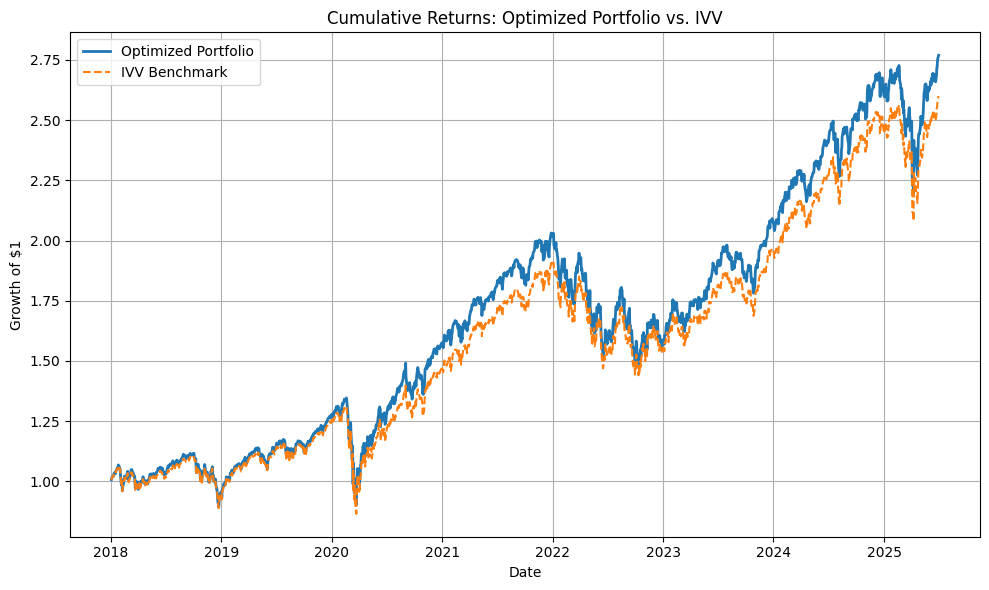

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_portfolio, label='Optimized Portfolio', linewidth=2)
plt.plot(cumulative_ivv, label='IVV Benchmark', linestyle='--')
plt.title('Cumulative Returns: Optimized Portfolio vs. IVV')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()